### Machine Learning
# Homework 1: Recognizing Iris flowers using MLPs

# [Wagner Luiz](wlsantos@cmb.gov.br)
#### [Instituto de Computação](http://www.ic.uff)
#### [Universidade Federal Fluminense](http://www.uff.br)
$\newcommand{\vec}[1]{\boldsymbol{#1}}$

## Introdução

O presente trabalho é um clássico problema de reconhecimento de flores a partir de conjunto de dados( altura e largura de sepalas e petalas).
Para o desenvolvimento deste trabalho existem algumas premissas a serem obedecidas, como uma rede neural multi-camadas e treinamentos utilizando backpropagation.
Considerando as boas práticas expostas em sala de aula, a implementação observou as seguintes fases:
* Pré-processamento dos dados.
* Separação dos conjuntos em treino, teste e validação.
* Inicialização dos pesos.
* Possibilidade de uso das funções de ativação sigmoid e tanh.
* Análise da evolução da acurácia da solução.
* Matriz de confusão.


### Pré-processamento dos dados

A primeira tarefa após a aquisição do conjunto de dados das flores iris é o pré-processamento para normalizar os dados de entrada e binarizar os de saída.

In [1]:
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Carregar dataset
iris = load_iris()
# Separa em dados de entrada e saida
X = iris.data
y = iris.target

# Faz um preprocessamentos dos dados de entrada para normalizar
normalized_X = preprocessing.normalize(X)
n_samples, n_features = iris.data.shape
print('Qtd. de exemplos',n_samples,'qtd. caracteristicas',n_features)
print('Exemplo sem normalização->',X[0],'normalizado->',normalized_X[0])
# Processamento de conjunto de saida para binarizar
lb = preprocessing.LabelBinarizer()
binarized_Y=lb.fit_transform(y)

print(iris.target_names)


/Users/wagnerluizoliveiradossantos/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Qtd. de exemplos 150 qtd. caracteristicas 4
Exemplo sem normalização-> [ 5.1  3.5  1.4  0.2] normalizado-> [ 0.80377277  0.55160877  0.22064351  0.0315205 ]
['setosa' 'versicolor' 'virginica']


### Separação dos conjuntos
  Uma vez tratados os dados de x e y, é necessário separar todas as informações existentes em três sub-conjuntos.  
   * Treino - para ajuste do modelo.
   * Validação - para usar durante o treinamento, e definir se ele esta indo bem e quando parar.
   * teste - para usar após o treinamento para validar a qualidade do modelo.


In [2]:
#Separa em dados de treino,teste e validacao
x_train, x_restante, y_train, y_restante = train_test_split(normalized_X,binarized_Y
                                                    ,train_size=0.6)
x_val, x_test, y_val, y_test = train_test_split(x_restante,y_restante
                                                    ,train_size=0.5)

print('Tamanho do DataSet total',len(iris.data))
print('Tamanho do DataSet treino',len(x_train))
print('Tamanho do DataSet validação',len(x_val))
print('Tamanho do DataSet teste',len(x_test))

Tamanho do DataSet total 150
Tamanho do DataSet treino 90
Tamanho do DataSet validação 30
Tamanho do DataSet teste 30


### Função de ativação
Foram implementadas três funções de ativação
* sigmoid
* tanh
* Rectified Linear Uni

In [3]:
#funcao logistica
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

#derivada logistica
def sigmoid_prime(x):
    return sigmoid(x)*(1.0-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1.0 - x**2

def ret(x):
    return np.max((x, np.zeros_like(x)), axis=0)

def ret_prime(x):
    return  np.max((np.sign(x), np.zeros_like(x)), axis=0)


### Implementação do MLP
Abaixo segue a implementação de uma rede neural multi camadas utilizando o treinamento backpropagation.


In [4]:
class WagnerMLP:

    def __init__(self, params=None):
        
        layers=np.array(params['layers'])
        activation=params['activation']
        self.learning_rate=params['learning_rate']
        self.epochs=params['epochs']
        self.period=params['period']
        self.x_val=params['x_val']
        self.y_val=params['y_val']
        self.train_errors=[]
        self.validation_errors=[]
        self.activation=params['activation']
        self.activation_prime=params['activation_prime']
        self.weights = []
        # definicao de pesos exemplo layers = [4,4,3]
        # define pesos da camadas ocultas - random((4+1, 4+1)) : 5 x 5
        #soma 1 por causa do bias
        for i in range(1, len(layers) - 1):
            r = np.random.random((layers[i-1] + 1, layers[i] + 1))*0.05
            self.weights.append(r)#1       
        # define os pesos da camadas de saida - random((4+1, 3)) : 5 x 3
        r = np.random.random((layers[i]+ 1, layers[i+1]))*0.05
        self.weights.append(r)#2
    
    def estimateError(self, x,y):
        totalError=0
        for i, xtest in enumerate(x):
            resultado = self.propagate(xtest)
            if(np.argmax(y[i])!=resultado):totalError+=1
        return (totalError*100)/len(x)
        pass
    
    def learn(self, X, y):
        # Adiciona mais uma coluna por causa do bias com o valor 1
        ones = np.atleast_2d(np.ones(X.shape[0]))
        X = np.concatenate((ones.T, X), axis=1)
        
        for k in range(self.epochs):
            #varre todos os elementos de X para treinar
            totalError=0
            for i,xx in enumerate(X):
                a = [X[i]]
                #varre todas as camadas em ordem do MLP, multiplicando o pesos pelas entradas 
                #do perceptro e propagando o resultado para a proxima camada
                for l in range(len(self.weights)):
                        dot_value = np.dot(a[l], self.weights[l])
                        activation = self.activation(dot_value)
                        a.append(activation)
                        
                # calcula a diferença entre o resultado preditado e o esperado na saida da ultima camada
                error = y[i] - a[-1]
                # calcula o delta com a funcao derivada de ativacao
                deltas = [error * self.activation_prime(a[-1])]

                if(np.argmax(y[i])!=np.argmax(a[-1])):totalError+=1
                    
                if ((k % self.period == 0)&(i==len(X)-1)):
                    percentual_Error=(totalError*100)/len(X)
                    print('epoca ',k+1,'Total erros na epoca',totalError,'Percentual de error(%)',percentual_Error)
                    self.train_errors.append(percentual_Error)
                    
                # Precisamos começar na penultima camadas
                # anterior a camada de saida
                for l in range(len(a) - 2, 0, -1): 
                    deltas.append(deltas[-1].dot(self.weights[l].T)*self.activation_prime(a[l]))

                # reversão
                # [camada3(saida)->camada2(oculta)]  => [camada2(oculta)->camada3(saida)]
                deltas.reverse()

                # backpropagation
                # 1. Multiplica o delta de saida pelo entrada de ativacao
                #    para obter o gradiente do peso
                # 2. subtraia um percentual do gradiente do peso
                for i in range(len(self.weights)):
                    layer = np.atleast_2d(a[i])
                    delta = np.atleast_2d(deltas[i])
                    self.weights[i] += self.learning_rate * layer.T.dot(delta)
                    
            if (k % self.period == 0):
                self.validation_errors.append(np.sum(self.estimateError(self.x_val,self.y_val)))
                    
    def propagate(self, x): 
        a = np.concatenate((np.ones(1).T, np.array(x)), axis=0)      
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))
        return np.argmax(a)

### Execução principal
Neste trecho é chamada a classe WagnerMLP com um conjuto de parametros predefinidos e submetida um treinamento.
Sendo:
* 'layers': Quantidade de perceptos em cada camadas do MLP.
* 'activation' e 'activation_prime' as funções de ativação.
* 'learning_rate': A taxa de aprendizagem.
* 'epochs': Quantidade de epocas para treinamento.
* 'period': Peridicidade que é calculada a evolução de aprendizagem para print de log e montagem do gráfico.
* 'x_val' e 'y_val': Conjunto de validação usado durante a aprendizagem.




In [5]:
if __name__ == '__main__':
    #params={'layers':[4,6,3],'activation':sigmoid,'activation_prime':sigmoid_prime,'learning_rate':0.05,'epochs':1,'period':500,'x_val':x_val,'y_val':y_val}
    params={'layers':[4,8,6,3],'activation':ret,'activation_prime':ret_prime,'learning_rate':0.005,'epochs':2000,'period':500,'x_val':x_val,'y_val':y_val}
    #params={'layers':[4,10,6,3],'activation':tanh,'activation_prime':tanh_prime,'learning_rate':0.01,'epochs':2000,'period':100,'x_val':x_val,'y_val':y_val}
    nn = WagnerMLP(params)
    nn.learn(x_train, y_train)
    resposta=[]
    for idx,e in enumerate(x_test):
        resposta.append(nn.propagate(e))
    
    from sklearn.metrics import confusion_matrix
    cm=confusion_matrix(lb.inverse_transform(y_test), resposta)
    print(cm)

epoca  1 Total erros na epoca 59 Percentual de error(%) 65.55555555555556
epoca  501 Total erros na epoca 7 Percentual de error(%) 7.777777777777778
epoca  1001 Total erros na epoca 4 Percentual de error(%) 4.444444444444445
epoca  1501 Total erros na epoca 3 Percentual de error(%) 3.3333333333333335
[[13  0  0]
 [ 0 11  0]
 [ 0  0  6]]


### Matriz de confusão
A matriz abaixo fornece um mapa das classificações esperadas e preditas em um conjunto de dados de testes.

Confusion matrix, without normalization
[[13  0  0]
 [ 0 11  0]
 [ 0  0  6]]


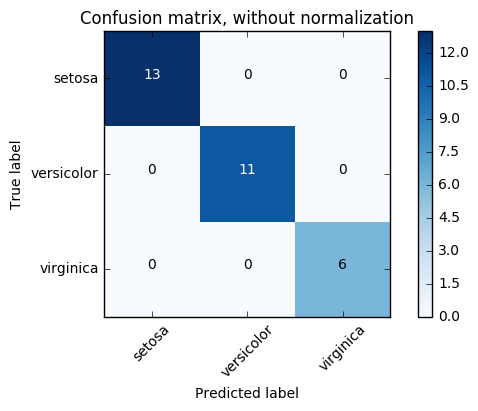

In [6]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(cm, classes=iris.target_names,
                      title='Confusion matrix, without normalization')
plt.show()

### Gráficos de erro x época
Este gráfico mostra a evolução da acurácia do treinamento sobre os conjuntos de treinamento e validação

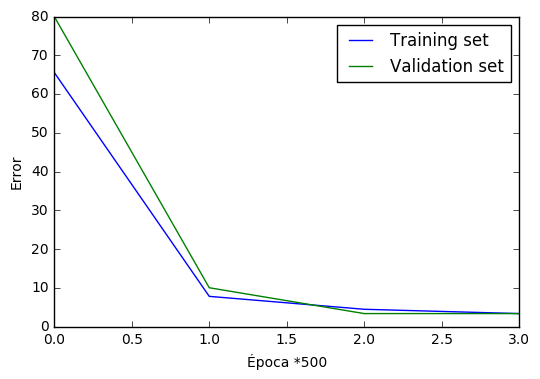

In [7]:
plt.plot(nn.train_errors, label='Training set')
plt.plot(nn.validation_errors, label='Validation set')
plt.legend(loc='best', frameon=True)
xlabel='Época *'+str(nn.period)
plt.xlabel(xlabel);plt.ylabel('Error')